Configuración inicial.

Nota sobre la Configuración del Entorno

Para asegurar la estabilidad del procesamiento en este entorno, se ha optado por utilizar `OpenJDK 17` en lugar de `OpenJDK 8`.

Aunque originalmente se consideró el uso de la versión 8, las actualizaciones recientes en las imágenes de Google Colab (que operan con Python 3.12) presentan una mejor compatibilidad con versiones más actuales de la Java Virtual Machine (JVM). El uso de Java 17 permite que el `Py4J Gateway` (el puente de comunicación entre Python y Spark y que nos dio multiples errores y dolores de cabeza) funcione de manera más fluida, evitando errores de conexión y optimizando la gestión de memoria durante las tareas de agregación masiva y shuffling.

Este ajuste no afecta la lógica de las consultas de Spark SQL, pero garantiza un entorno de ejecución más robusto y evitó problemas de configuración estando preparado para las demandas de procesamiento de Big Data.

In [ ]:
!pip install pyspark
!apt-get install openjdk-17-jdk -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + r"\bin;" + os.environ["PATH"]
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"


# Punto 1

El jugador más “retador” y el jugador más “retado”.

> Add blockquote



Alternativa sobre DF
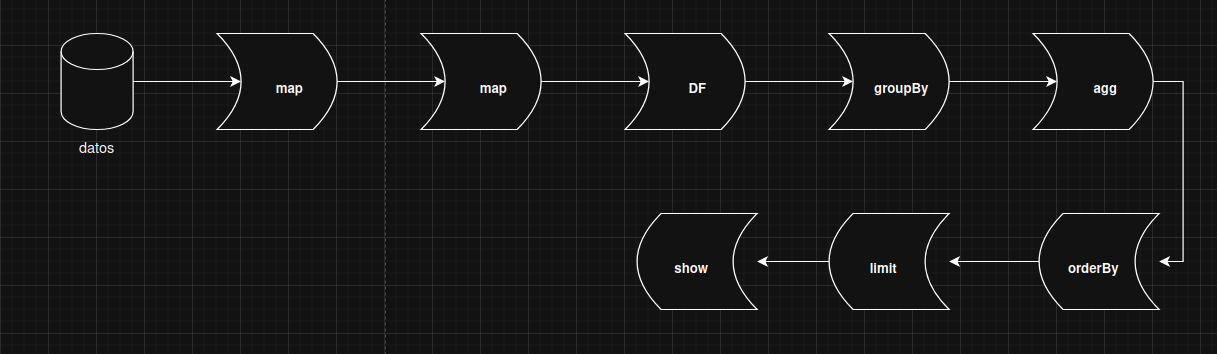

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext, Row
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count, desc, row_number
from pyspark.sql.window import Window
import os

spark = SparkSession.builder \
    .appName("TP2 - Punto 1 (jugadores.txt)") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
scsql = SQLContext(sc)

root_path = '/content/datos/'
jugadores = sc.textFile(root_path + "datos.txt")
jugadores = jugadores.map(lambda t : t.split("\t"))
jugadores = jugadores.map(lambda t : Row(ID_Jug_Retador = int(t[0]),
                                          ID_Jugador_Retado  = int(t[1]),
                                          Puntos = int(t[2]), Tiempo = int(t[3])))
jugadores = scsql.createDataFrame(jugadores)

# Jugador más "Retador"
# Agrupamos por el el ID del retador y contamos filas
jugador_mas_retador = jugadores.groupBy("ID_Jug_Retador") \
    .count() \
    .orderBy(F.col("count").desc()) \
    .limit(1)

# Jugador más "Retado"
# Agrupamos por el ID del oponente y contamos filas
jugador_mas_retado = jugadores.groupBy("ID_Jugador_Retado") \
    .count() \
    .orderBy(F.col("count").desc()) \
    .limit(1)

print("El jugador que más veces ha iniciado combates (más retador) es:")
jugador_mas_retador.show()

print("El jugador que más veces ha sido elegido como oponente (más retado) es:")
jugador_mas_retado.show()

Alternativa Usando SQL puro

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext, Row
from pyspark.sql.functions import col, count, desc, row_number
from pyspark.sql.window import Window
import os

spark = SparkSession.builder \
    .appName("TP2 - Punto 1 (jugadores.txt)") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
scsql = SQLContext(sc)

root_path = '/content/datos/'
partidas = sc.textFile(root_path + "datos.txt")
partidas = partidas.map(lambda t : t.split("\t"))
partidas = partidas.map(lambda t : Row(ID_Jugador_Retador = int(t[0]),
                                          ID_Jugador_Retado  = int(t[1]),
                                          Puntos = int(t[2]), Tiempo = int(t[3])))
partidas = scsql.createDataFrame(partidas)
partidas.registerTempTable("partidas")
resultado = spark.sql("""
    SELECT
        ID_Jugador_Retador AS Mas_Retador,
        COUNT(*) AS ocurrencias
    FROM partidas
    GROUP BY ID_Jugador_Retador
    ORDER BY ocurrencias DESC
    LIMIT 1
""")
print("El jugador que más veces ha iniciado combates (más retador) es:")
resultado.show()

resultado = spark.sql("""
    SELECT
        ID_Jugador_Retado AS Mas_Retado,
        COUNT(*) AS ocurrencias
    FROM partidas
    GROUP BY ID_Jugador_Retado
    ORDER BY ocurrencias DESC
    LIMIT 1
""")
print("El jugador que más veces ha sido elegido como oponente (más retado) es:")
resultado.show()

# Punto 2

El jugador que más puntos obtuvo en promedio :

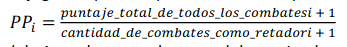

(el +1 en el numerador y en el denominador es para evitar divisiones por cero en el caso
que un jugador no haya “retado” a nadie, en cuyo caso tendrá el puntaje mínimo de 1).

DAG:

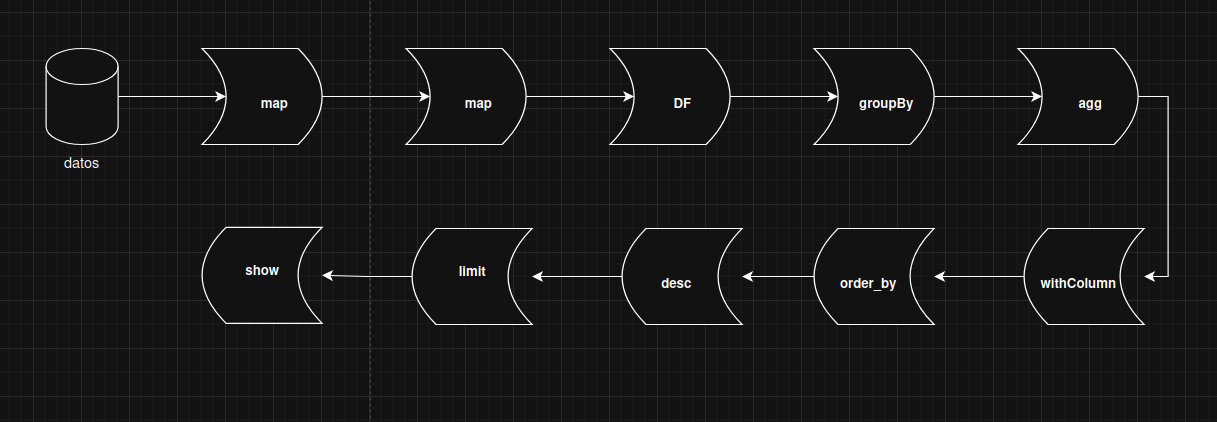

In [ ]:
from pyspark.sql import functions as F

# 1. Agrupamos por retador y calculamos las métricas base
ranking_puntos = jugadores.groupBy("ID_Jug_Retador").agg(
    F.sum("Puntos").alias("suma_puntos"),
    F.count("*").alias("total_combates")
)

# 2. Aplicamos la fórmula matemática para crear la nueva columna
ranking_puntos = ranking_puntos.withColumn(
    "promedio_ponderado",
    (F.col("suma_puntos") + 1) / (F.col("total_combates") + 1)
)

# 3. Obtenemos al mejor
mejor_promedio = ranking_puntos.orderBy(F.col("promedio_ponderado").desc()).limit(1)

mejor_promedio.show()

In [ ]:
resultado = spark.sql("""
  SELECT
    ID_Jugador_Retador,
    SUM(Puntos) AS puntos_totales,
    COUNT(*) AS cantidad_combates,
    (SUM(Puntos) + 1) / (COUNT(*) + 1) AS promedio_puntos
  FROM partidas
  GROUP BY ID_Jugador_Retador
  ORDER BY promedio_puntos DESC
  LIMIT 1;
""")
resultado.show()

# Punto 3

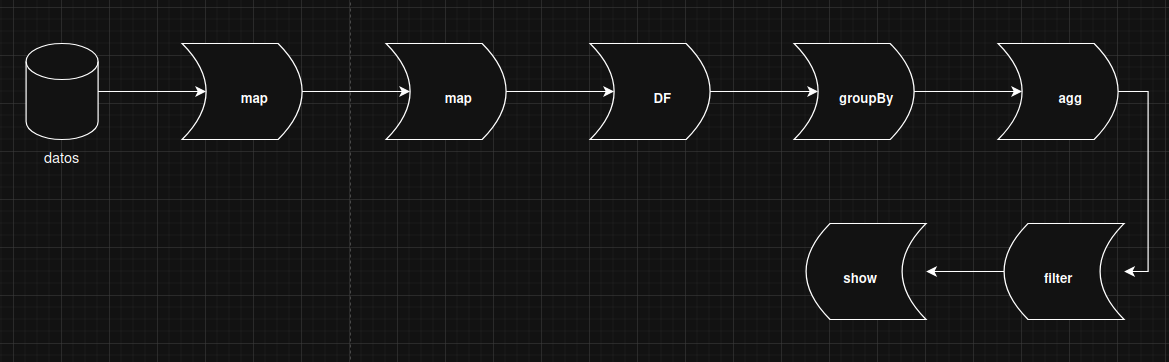

In [ ]:
# Definimos el parámetro H
H = 12

jugadores_top_h = jugadores.groupBy("ID_Jug_Retador") \
    .agg(F.countDistinct("ID_Jugador_Retado").alias("oponentes_distintos")) \
    .filter(F.col("oponentes_distintos") >= H)

jugadores_top_h.show()


In [ ]:
H = 12
resultado = spark.sql(f"""
  SELECT
      ID_Jugador_Retador AS Mas_Retador,
      COUNT(DISTINCT ID_Jugador_Retado) AS Ocurrencias
  FROM partidas
  GROUP BY ID_Jugador_Retador
  HAVING Ocurrencias >= {H}
  ORDER BY Ocurrencias DESC;
""")
resultado.show()

# Punto 4

El top 10 de los jugadores con mejor puntaje heroico. El puntaje PH de un jugador i se
calcula como:

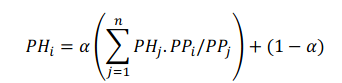

donde n es la cantidad de jugadores “retados” por el jugador i, PHj es el puntaje P del j-ésimo jugador retado por i, PPi el puntaje promedio del jugador i, PPj el puntaje promedio del j-ésimo jugador retado por i y 𝛼 es un parámetro del algoritmo.
Cómo para calcular el puntaje PH de un jugador i previamente hay que calcular el
puntaje de los jugadores a quiénes retó (y a su vez éstos pueden haber retado al jugador i), el cálculo se realiza de manera iterativa.
Se comienza asignando el mismo puntaje heroico con un valor arbitrario a todos los jugadores (tiempo 0), con esos puntajes arbitrarios se calcula el puntaje usando la fórmula detallada para obtener los nuevos puntajes (tiempo 1), con éstos se calculan los nuevos puntajes (tiempo 2) y así se continúa hasta alcanzar una convergencia en los valores. Al final de este documento hay un ejemplo que explica este cálculo iterativo.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, trim, lit, sum as _sum, count, countDistinct
import pyspark.sql.functions as F
import os

spark = SparkSession.builder \
    .appName("TP2 - Spark pipeline (Puntaje Heroico)") \
    .master("local[*]") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
scsql = SQLContext(sc)

root_path = '/content/datos/'
partidas = sc.textFile(root_path + "datos.txt")

partidas = partidas.map(lambda t : t.split("\t"))
partidas = partidas.map(lambda t : Row(ID_Jugador_Retador = int(t[0]),
                                          ID_Jugador_Retado  = int(t[1]),
                                          Puntos = int(t[2]), Tiempo = int(t[3])))
partidas = spark.createDataFrame(partidas)

partidas.show(5, truncate=False)

df_sum = partidas.groupBy("ID_Jugador_Retador").agg(
    ((_sum("Puntos") + lit(1)) / (count("*") + lit(1))).alias("pp")
)
df_pp = partidas.groupBy("ID_Jugador_Retador").agg(
    ((_sum("Puntos") + lit(1)) / (count("*") + lit(1))).alias("pp")
).withColumnRenamed("ID_Jugador_Retador", "jugador")

# Cacheamos porque se usará en cada iteración del bucle
df_pp.persist()

print("\n====CALCULAR PUNTAJE HEROICO ====")

ids_retadores = partidas.select(col("ID_Jugador_Retador").alias("jugador"))
ids_retados = partidas.select(col("ID_Jugador_Retado").alias("jugador"))

df_ph = ids_retadores.union(ids_retados).distinct().withColumn("ph_prev", lit(1.0))

# Parámetros
alpha, error, max_iter = 0.1, 0.001, 50

for i in range(max_iter):
    # Unimos partidas con PP del retador, PP del retado y PH del retado
    df_join = partidas.join(df_pp, partidas.ID_Jugador_Retador == df_pp.jugador, "left") \
        .withColumnRenamed("pp", "pp_retador").drop("jugador") \
        .join(df_pp, partidas.ID_Jugador_Retado == df_pp.jugador, "left") \
        .withColumnRenamed("pp", "pp_retado").drop("jugador") \
        .join(df_ph, partidas.ID_Jugador_Retado == df_ph.jugador, "left") \
        .withColumnRenamed("ph_prev", "ph_prev_retado").drop("jugador") \
        .fillna(1.0)

    # Cálculo de contribución y nuevo PH
    df_new_ph = df_join.withColumn("contrib", col("ph_prev_retado") * (col("pp_retador") / col("pp_retado"))) \
        .groupBy("ID_Jugador_Retador") \
        .agg((alpha * _sum("contrib") + (1 - alpha)).alias("ph_prev")) \
        .withColumnRenamed("ID_Jugador_Retador", "jugador")
    df_new_ph.show(5)
    # --- CONTROL DE CONVERGENCIA ---
    # Para calcular la diferencia, unimos el viejo con el nuevo, renombro para que Spark pueda usarlo
    df_ph_old = df_ph.withColumnRenamed("ph_prev", "ph_antiguo")
    df_ph_new = df_new_ph.withColumnRenamed("ph_prev", "ph_nuevo")

    # Ahora el join no tendrá nombres duplicados
    diff_df = df_ph_new.join(df_ph_old, "jugador") \
        .selectExpr("abs(ph_nuevo - ph_antiguo) as diff")

    # Calculamos el error promedio
    stats = diff_df.agg(_sum("diff"), count("*")).collect()[0]
    error_actual = stats[0] / stats[1] if stats[1] > 0 else 0

    print(f"Iteración {i+1} - Error: {error_actual:.4f}")

    # Actualizamos para la siguiente iteración
    df_ph.unpersist()
    df_ph = df_new_ph.persist()

    if error_actual < error:
        break

print("\n========== TOP 10 FINAL ==========")
top10 = df_ph.orderBy(col("ph_prev").desc()).limit(10)
top10.show()

spark.stop()

# Reflexión final

El uso del framework Spark trajo comodidades y mejoras considerables.

- Spark SQL permite usar SQL declarativo o la API de DataFrames. En lugar de programar el cómo (paso a paso con el MAP, REDUCE, COMBINER), le dices al sistema el qué datos quieres. Esto hace que el código sea mucho más legible, mantenible y corto. La utilización de SQL fue la mejor parte de esta segunda entrega, hizo que todo el entorno sea mucho más familiar.

- Notamos BASTANTE más lento a Spark que MapReduce, no estamos seguros el motivo. En principio creímos que, al correr MapReduce de manera local, y Spark en Google Colab. Por ese motivo no lo consideramos con tanto peso al momento de compararlos.

- El inciso 4, el más complejo y rebuscado de todos, fue resuelto (en su mayoría) sin complicaciones en Spark. En comparación a lo rebuscado que fue en MapReduce. La legibilidad y orden es la cualidad que más destacamos de este framework.

- La mayor desventaja de Spark, fue lo incomodo que es hacer DAGs. Resultan muy grandes al tener que especificar todas y cada una de las operaciones en el orden en que se ejecutan y las entradas de las siguientes (el del inciso 4 no fue adjuntado debido a que resultó ilegible de lo extenso que es).

Consideramos y encontramos mucho más reconfortante trabajar con Spark que con MapReduce, fue considerablemente más llevadero.